# Assignment

In [1]:
import torch
from torch import nn
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
def minmax_norm(x):
    return (x - x.min(axis=0).values) / (x.max(axis=0).values - x.min(axis=0).values)

In [3]:
def calc_acc(data, labels, model):
    count, total = 0, len(labels)
    with torch.no_grad():
        for vector, label in zip(data, labels):
            count += (model(vector).argmax() == label).sum().item()
    return count*100/total
        
def train(data, labels, model, optimizer, loss_fn, epochs, threshold, return_errors=False, **kwargs):
    prev_error, error, epoch, res = 0, 1e9, 1, {}
    if kwargs.get('errors'):
        errors = []
    if kwargs.get('accuracy'):
        train_accs, val_accs = [], []
    while abs(error - prev_error) > threshold and epoch <= epochs:
        prev_error = error
        error = 0
        print(f'Epoch {epoch}\n----------------------------------------')
        for vector, label in zip(data, labels):
            # calc loss
            pred = model(vector)
            loss = loss_fn(pred, label)
            error += loss.item()
            # param update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        error = error/len(labels)
        if kwargs.get('errors'):
            errors.append(error)
        epoch += 1
        if kwargs.get('accuracy'):
            train_acc = calc_acc(data, labels, model)
            val_acc = calc_acc(kwargs.get('val_data'), kwargs.get('val_labels'), model)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            print(f'Train accuracy = {train_acc:.2f}')
            print(f'Validation accuracy = {val_acc:.2f}')
        print(f'Loss = {error:.6f}')
        print(f'Diff = {abs(error-prev_error):.6f}')
        print()
    if kwargs.get('errors'):
        res['errors'] = errors
    if kwargs.get('accuracy'):
        res['train_accs'] = train_accs
        res['val_accs'] = val_accs
    return res

In [4]:
def load_data(which):
    os.chdir('/home/pongthang/Downloads/handwritten')
    filenames = glob(f'*/{which}/*.txt')
    data, labels = [], []
    for filename in filenames:
        with open(filename, 'r') as in_file:
            points = [float(x) for x in in_file.read().split()[1:]]
            data.append(minmax_norm(torch.tensor(list(zip(points[::2], points[1::2])), dtype=torch.float32)))
        labels.append(filename.split('/')[0])
    classes = np.unique(labels)
    class2index = {x: i for i, x in enumerate(classes)}
    labels = torch.tensor([class2index[x] for x in labels])
    data_ = data
    # shuffle data
    random_indices = torch.randperm(len(labels))
    data = [data_[i] for i in random_indices]
    labels = labels[random_indices]
    return data, labels, class2index

In [5]:
train_data, train_label, class2index = load_data('train')
test_data, test_label, _ = load_data('dev')

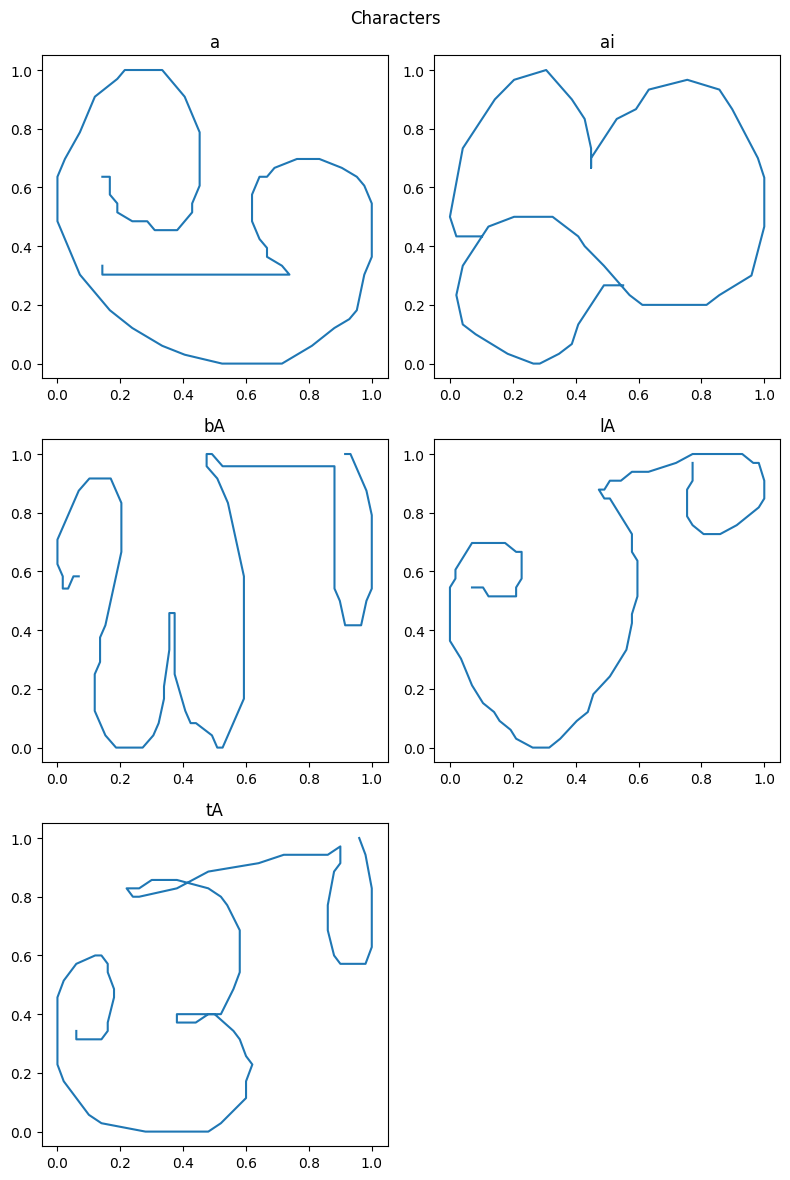

In [6]:
fig = plt.figure(figsize=(8, 12))
h, w = 3, 2
for label, index in class2index.items():
    ax = fig.add_subplot(h, w, index+1)
    ax.plot(*train_data[(train_label == index).nonzero()[0].item()].T)
    ax.set_title(label)
fig.suptitle('Characters')
fig.tight_layout()

In [24]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(2, 5, 2)
        self.fcnn = nn.Sequential(
            nn.Linear(5, 5),
            nn.Softmax(dim=1)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, X):
        output, hn = self.rnn(X)
        return self.fcnn(output)[-1]

In [26]:
rnn = RNN()

In [27]:
res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)

Epoch 1
----------------------------------------
Loss = 1.597084
Diff = 999999998.402916

Epoch 2
----------------------------------------
Loss = 1.527327
Diff = 0.069757

Epoch 3
----------------------------------------
Loss = 1.473161
Diff = 0.054166

Epoch 4
----------------------------------------
Loss = 1.459156
Diff = 0.014005

Epoch 5
----------------------------------------
Loss = 1.451226
Diff = 0.007930

Epoch 6
----------------------------------------
Loss = 1.444849
Diff = 0.006377

Epoch 7
----------------------------------------
Loss = 1.440427
Diff = 0.004422

Epoch 8
----------------------------------------
Loss = 1.434190
Diff = 0.006237

Epoch 9
----------------------------------------
Loss = 1.426993
Diff = 0.007197

Epoch 10
----------------------------------------
Loss = 1.416434
Diff = 0.010559

Epoch 11
----------------------------------------
Loss = 1.398838
Diff = 0.017597

Epoch 12
----------------------------------------
Loss = 1.370627
Diff = 0.028211

Epoch

In [37]:
print(f'Training accuracy = {calc_acc(train_data, train_label, rnn)}')

Training accuracy = 59.475218658892125


In [38]:
print(f'Test accuracy = {calc_acc(test_data, test_label, rnn)}')

Test accuracy = 60.0


# Hyperparameter testing

In [48]:
%%time
errors = []
results = []
for hidden_size in range(1, 100):
    print(f'--------------------- Hidden size: {hidden_size} ---------------------')
    rnn = RNN(2, hidden_size, 5)
    res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- Hidden size: 1 ---------------------
Epoch 1
----------------------------------------
Loss = 1.606612
Diff = 999999998.393388

Epoch 2
----------------------------------------
Loss = 1.604909
Diff = 0.001703

Epoch 3
----------------------------------------
Loss = 1.602993
Diff = 0.001916

Epoch 4
----------------------------------------
Loss = 1.600745
Diff = 0.002248

Epoch 5
----------------------------------------
Loss = 1.598013
Diff = 0.002732

Epoch 6
----------------------------------------
Loss = 1.594575
Diff = 0.003438

Epoch 7
----------------------------------------
Loss = 1.590079
Diff = 0.004495

Epoch 8
----------------------------------------
Loss = 1.583915
Diff = 0.006164

Epoch 9
----------------------------------------
Loss = 1.574906
Diff = 0.009009

Epoch 10
----------------------------------------
Loss = 1.560596
Diff = 0.014310

Epoch 11
----------------------------------------
Loss = 1.536506
Diff = 0.024089

Epoch 12
--------------------

Loss = 1.433611
Diff = 0.000443

Epoch 18
----------------------------------------
Loss = 1.433243
Diff = 0.000369

Epoch 19
----------------------------------------
Loss = 1.432932
Diff = 0.000310

Epoch 20
----------------------------------------
Loss = 1.432657
Diff = 0.000276

Epoch 21
----------------------------------------
Loss = 1.432388
Diff = 0.000269

Epoch 22
----------------------------------------
Loss = 1.432103
Diff = 0.000285

Epoch 23
----------------------------------------
Loss = 1.431804
Diff = 0.000299

Epoch 24
----------------------------------------
Loss = 1.431504
Diff = 0.000300

Epoch 25
----------------------------------------
Loss = 1.431197
Diff = 0.000307

Epoch 26
----------------------------------------
Loss = 1.430879
Diff = 0.000317

Epoch 27
----------------------------------------
Loss = 1.430553
Diff = 0.000326

Epoch 28
----------------------------------------
Loss = 1.430217
Diff = 0.000337

Epoch 29
----------------------------------------
Loss

Loss = 1.434391
Diff = 0.001245

Epoch 18
----------------------------------------
Loss = 1.433067
Diff = 0.001324

Epoch 19
----------------------------------------
Loss = 1.432140
Diff = 0.000927

Epoch 20
----------------------------------------
Loss = 1.430863
Diff = 0.001278

Epoch 21
----------------------------------------
Loss = 1.429726
Diff = 0.001137

Epoch 22
----------------------------------------
Loss = 1.428891
Diff = 0.000835

Epoch 23
----------------------------------------
Loss = 1.426480
Diff = 0.002411

Epoch 24
----------------------------------------
Loss = 1.426995
Diff = 0.000515

Epoch 25
----------------------------------------
Loss = 1.425965
Diff = 0.001030

Epoch 26
----------------------------------------
Loss = 1.424899
Diff = 0.001065

Epoch 27
----------------------------------------
Loss = 1.424817
Diff = 0.000083

--------------------- Hidden size: 5 ---------------------
Epoch 1
----------------------------------------
Loss = 1.601197
Diff = 999999

Loss = 1.420360
Diff = 0.040484

Epoch 90
----------------------------------------
Loss = 1.399881
Diff = 0.020479

Epoch 91
----------------------------------------
Loss = 1.392104
Diff = 0.007777

Epoch 92
----------------------------------------
Loss = 1.413829
Diff = 0.021725

Epoch 93
----------------------------------------
Loss = 1.387448
Diff = 0.026381

Epoch 94
----------------------------------------
Loss = 1.438464
Diff = 0.051016

Epoch 95
----------------------------------------
Loss = 1.395402
Diff = 0.043062

Epoch 96
----------------------------------------
Loss = 1.414802
Diff = 0.019401

Epoch 97
----------------------------------------
Loss = 1.398807
Diff = 0.015995

Epoch 98
----------------------------------------
Loss = 1.393795
Diff = 0.005012

Epoch 99
----------------------------------------
Loss = 1.386730
Diff = 0.007065

Epoch 100
----------------------------------------
Loss = 1.387498
Diff = 0.000768

--------------------- Hidden size: 6 ----------------

Loss = 1.426504
Diff = 0.000472

Epoch 15
----------------------------------------
Loss = 1.425446
Diff = 0.001058

Epoch 16
----------------------------------------
Loss = 1.421997
Diff = 0.003449

Epoch 17
----------------------------------------
Loss = 1.418874
Diff = 0.003123

Epoch 18
----------------------------------------
Loss = 1.416752
Diff = 0.002122

Epoch 19
----------------------------------------
Loss = 1.415609
Diff = 0.001144

Epoch 20
----------------------------------------
Loss = 1.417595
Diff = 0.001986

Epoch 21
----------------------------------------
Loss = 1.423877
Diff = 0.006283

Epoch 22
----------------------------------------
Loss = 1.421309
Diff = 0.002569

Epoch 23
----------------------------------------
Loss = 1.420346
Diff = 0.000962

Epoch 24
----------------------------------------
Loss = 1.419366
Diff = 0.000980

Epoch 25
----------------------------------------
Loss = 1.418643
Diff = 0.000724

Epoch 26
----------------------------------------
Loss

Loss = 1.435470
Diff = 0.000419

Epoch 13
----------------------------------------
Loss = 1.435081
Diff = 0.000389

Epoch 14
----------------------------------------
Loss = 1.434751
Diff = 0.000330

Epoch 15
----------------------------------------
Loss = 1.434490
Diff = 0.000261

Epoch 16
----------------------------------------
Loss = 1.434244
Diff = 0.000245

Epoch 17
----------------------------------------
Loss = 1.433984
Diff = 0.000260

Epoch 18
----------------------------------------
Loss = 1.433788
Diff = 0.000197

Epoch 19
----------------------------------------
Loss = 1.433703
Diff = 0.000085

--------------------- Hidden size: 9 ---------------------
Epoch 1
----------------------------------------
Loss = 1.608317
Diff = 999999998.391683

Epoch 2
----------------------------------------
Loss = 1.540563
Diff = 0.067755

Epoch 3
----------------------------------------
Loss = 1.463511
Diff = 0.077052

Epoch 4
----------------------------------------
Loss = 1.449468
Diff = 0

Loss = 1.434930
Diff = 0.000504

Epoch 15
----------------------------------------
Loss = 1.434473
Diff = 0.000457

Epoch 16
----------------------------------------
Loss = 1.434050
Diff = 0.000424

Epoch 17
----------------------------------------
Loss = 1.433677
Diff = 0.000373

Epoch 18
----------------------------------------
Loss = 1.433387
Diff = 0.000289

Epoch 19
----------------------------------------
Loss = 1.433142
Diff = 0.000245

Epoch 20
----------------------------------------
Loss = 1.432759
Diff = 0.000382

Epoch 21
----------------------------------------
Loss = 1.432387
Diff = 0.000373

Epoch 22
----------------------------------------
Loss = 1.431588
Diff = 0.000798

Epoch 23
----------------------------------------
Loss = 1.430834
Diff = 0.000755

Epoch 24
----------------------------------------
Loss = 1.430256
Diff = 0.000577

Epoch 25
----------------------------------------
Loss = 1.429000
Diff = 0.001256

Epoch 26
----------------------------------------
Loss

Loss = 1.432389
Diff = 0.000680

Epoch 13
----------------------------------------
Loss = 1.432106
Diff = 0.000283

Epoch 14
----------------------------------------
Loss = 1.431043
Diff = 0.001063

Epoch 15
----------------------------------------
Loss = 1.429150
Diff = 0.001893

Epoch 16
----------------------------------------
Loss = 1.426175
Diff = 0.002975

Epoch 17
----------------------------------------
Loss = 1.424968
Diff = 0.001207

Epoch 18
----------------------------------------
Loss = 1.424726
Diff = 0.000242

Epoch 19
----------------------------------------
Loss = 1.424312
Diff = 0.000414

Epoch 20
----------------------------------------
Loss = 1.423905
Diff = 0.000407

Epoch 21
----------------------------------------
Loss = 1.423205
Diff = 0.000700

Epoch 22
----------------------------------------
Loss = 1.422060
Diff = 0.001145

Epoch 23
----------------------------------------
Loss = 1.420776
Diff = 0.001285

Epoch 24
----------------------------------------
Loss

Loss = 1.434351
Diff = 0.000488

Epoch 11
----------------------------------------
Loss = 1.434033
Diff = 0.000318

Epoch 12
----------------------------------------
Loss = 1.433401
Diff = 0.000631

Epoch 13
----------------------------------------
Loss = 1.433014
Diff = 0.000387

Epoch 14
----------------------------------------
Loss = 1.433687
Diff = 0.000673

Epoch 15
----------------------------------------
Loss = 1.433182
Diff = 0.000505

Epoch 16
----------------------------------------
Loss = 1.432779
Diff = 0.000404

Epoch 17
----------------------------------------
Loss = 1.432571
Diff = 0.000207

Epoch 18
----------------------------------------
Loss = 1.432057
Diff = 0.000515

Epoch 19
----------------------------------------
Loss = 1.431801
Diff = 0.000256

Epoch 20
----------------------------------------
Loss = 1.431053
Diff = 0.000748

Epoch 21
----------------------------------------
Loss = 1.430453
Diff = 0.000600

Epoch 22
----------------------------------------
Loss

Loss = 1.397214
Diff = 0.011421

Epoch 66
----------------------------------------
Loss = 1.391172
Diff = 0.006042

Epoch 67
----------------------------------------
Loss = 1.389899
Diff = 0.001273

Epoch 68
----------------------------------------
Loss = 1.358440
Diff = 0.031459

Epoch 69
----------------------------------------
Loss = 1.423469
Diff = 0.065029

Epoch 70
----------------------------------------
Loss = 1.373444
Diff = 0.050025

Epoch 71
----------------------------------------
Loss = 1.426394
Diff = 0.052950

Epoch 72
----------------------------------------
Loss = 1.435324
Diff = 0.008929

Epoch 73
----------------------------------------
Loss = 1.437173
Diff = 0.001849

Epoch 74
----------------------------------------
Loss = 1.435868
Diff = 0.001304

Epoch 75
----------------------------------------
Loss = 1.432867
Diff = 0.003001

Epoch 76
----------------------------------------
Loss = 1.429950
Diff = 0.002917

Epoch 77
----------------------------------------
Loss

Loss = 1.556634
Diff = 999999998.443366

Epoch 2
----------------------------------------
Loss = 1.462403
Diff = 0.094231

Epoch 3
----------------------------------------
Loss = 1.449302
Diff = 0.013101

Epoch 4
----------------------------------------
Loss = 1.438459
Diff = 0.010843

Epoch 5
----------------------------------------
Loss = 1.435683
Diff = 0.002775

Epoch 6
----------------------------------------
Loss = 1.445410
Diff = 0.009727

Epoch 7
----------------------------------------
Loss = 1.436061
Diff = 0.009349

Epoch 8
----------------------------------------
Loss = 1.432384
Diff = 0.003677

Epoch 9
----------------------------------------
Loss = 1.436526
Diff = 0.004143

Epoch 10
----------------------------------------
Loss = 1.432440
Diff = 0.004087

Epoch 11
----------------------------------------
Loss = 1.439396
Diff = 0.006956

Epoch 12
----------------------------------------
Loss = 1.431518
Diff = 0.007879

Epoch 13
----------------------------------------
Loss

Loss = 1.486294
Diff = 0.030816

Epoch 30
----------------------------------------
Loss = 1.430962
Diff = 0.055332

Epoch 31
----------------------------------------
Loss = 1.436541
Diff = 0.005580

Epoch 32
----------------------------------------
Loss = 1.430984
Diff = 0.005558

Epoch 33
----------------------------------------
Loss = 1.432055
Diff = 0.001071

Epoch 34
----------------------------------------
Loss = 1.434000
Diff = 0.001945

Epoch 35
----------------------------------------
Loss = 1.434176
Diff = 0.000175

Epoch 36
----------------------------------------
Loss = 1.435819
Diff = 0.001643

Epoch 37
----------------------------------------
Loss = 1.431268
Diff = 0.004551

Epoch 38
----------------------------------------
Loss = 1.433268
Diff = 0.002000

Epoch 39
----------------------------------------
Loss = 1.429608
Diff = 0.003660

Epoch 40
----------------------------------------
Loss = 1.431167
Diff = 0.001559

Epoch 41
----------------------------------------
Loss

Loss = 1.434840
Diff = 0.000565

Epoch 12
----------------------------------------
Loss = 1.434571
Diff = 0.000269

Epoch 13
----------------------------------------
Loss = 1.434326
Diff = 0.000245

Epoch 14
----------------------------------------
Loss = 1.434529
Diff = 0.000203

Epoch 15
----------------------------------------
Loss = 1.434294
Diff = 0.000235

Epoch 16
----------------------------------------
Loss = 1.433664
Diff = 0.000630

Epoch 17
----------------------------------------
Loss = 1.433263
Diff = 0.000402

Epoch 18
----------------------------------------
Loss = 1.433133
Diff = 0.000130

Epoch 19
----------------------------------------
Loss = 1.433234
Diff = 0.000100

Epoch 20
----------------------------------------
Loss = 1.434184
Diff = 0.000950

Epoch 21
----------------------------------------
Loss = 1.434405
Diff = 0.000222

Epoch 22
----------------------------------------
Loss = 1.432690
Diff = 0.001715

Epoch 23
----------------------------------------
Loss

Loss = 1.441997
Diff = 0.002711

Epoch 11
----------------------------------------
Loss = 1.436706
Diff = 0.005291

Epoch 12
----------------------------------------
Loss = 1.435183
Diff = 0.001523

Epoch 13
----------------------------------------
Loss = 1.434280
Diff = 0.000902

Epoch 14
----------------------------------------
Loss = 1.434498
Diff = 0.000218

Epoch 15
----------------------------------------
Loss = 1.434029
Diff = 0.000469

Epoch 16
----------------------------------------
Loss = 1.433349
Diff = 0.000680

Epoch 17
----------------------------------------
Loss = 1.433985
Diff = 0.000636

Epoch 18
----------------------------------------
Loss = 1.433653
Diff = 0.000332

Epoch 19
----------------------------------------
Loss = 1.433674
Diff = 0.000021

--------------------- Hidden size: 37 ---------------------
Epoch 1
----------------------------------------
Loss = 1.539036
Diff = 999999998.460964

Epoch 2
----------------------------------------
Loss = 1.450893
Diff 

Loss = 1.697277
Diff = 0.009602

Epoch 8
----------------------------------------
Loss = 1.445078
Diff = 0.252199

Epoch 9
----------------------------------------
Loss = 1.676105
Diff = 0.231027

Epoch 10
----------------------------------------
Loss = 1.704249
Diff = 0.028144

Epoch 11
----------------------------------------
Loss = 1.704249
Diff = 0.000000

--------------------- Hidden size: 40 ---------------------
Epoch 1
----------------------------------------
Loss = 1.546657
Diff = 999999998.453343

Epoch 2
----------------------------------------
Loss = 1.478281
Diff = 0.068376

Epoch 3
----------------------------------------
Loss = 1.447664
Diff = 0.030617

Epoch 4
----------------------------------------
Loss = 1.444132
Diff = 0.003532

Epoch 5
----------------------------------------
Loss = 1.435504
Diff = 0.008628

Epoch 6
----------------------------------------
Loss = 1.434811
Diff = 0.000693

Epoch 7
----------------------------------------
Loss = 1.675994
Diff = 0.241

Loss = 1.601759
Diff = 0.004766

Epoch 19
----------------------------------------
Loss = 1.442574
Diff = 0.159185

Epoch 20
----------------------------------------
Loss = 1.431797
Diff = 0.010777

Epoch 21
----------------------------------------
Loss = 1.431322
Diff = 0.000475

Epoch 22
----------------------------------------
Loss = 1.430417
Diff = 0.000905

Epoch 23
----------------------------------------
Loss = 1.431564
Diff = 0.001148

Epoch 24
----------------------------------------
Loss = 1.429579
Diff = 0.001985

Epoch 25
----------------------------------------
Loss = 1.443345
Diff = 0.013766

Epoch 26
----------------------------------------
Loss = 1.432581
Diff = 0.010764

Epoch 27
----------------------------------------
Loss = 1.431356
Diff = 0.001225

Epoch 28
----------------------------------------
Loss = 1.430373
Diff = 0.000983

Epoch 29
----------------------------------------
Loss = 1.430434
Diff = 0.000061

--------------------- Hidden size: 45 ----------------

Loss = 1.434591
Diff = 0.002520

Epoch 55
----------------------------------------
Loss = 1.433444
Diff = 0.001147

Epoch 56
----------------------------------------
Loss = 1.539876
Diff = 0.106432

Epoch 57
----------------------------------------
Loss = 1.564463
Diff = 0.024587

Epoch 58
----------------------------------------
Loss = 1.628061
Diff = 0.063598

Epoch 59
----------------------------------------
Loss = 1.625774
Diff = 0.002287

Epoch 60
----------------------------------------
Loss = 1.624226
Diff = 0.001549

Epoch 61
----------------------------------------
Loss = 1.496416
Diff = 0.127810

Epoch 62
----------------------------------------
Loss = 1.442887
Diff = 0.053529

Epoch 63
----------------------------------------
Loss = 1.443133
Diff = 0.000246

Epoch 64
----------------------------------------
Loss = 1.437941
Diff = 0.005193

Epoch 65
----------------------------------------
Loss = 1.437717
Diff = 0.000223

Epoch 66
----------------------------------------
Loss

Loss = 1.428791
Diff = 0.000462

Epoch 19
----------------------------------------
Loss = 1.428971
Diff = 0.000179

Epoch 20
----------------------------------------
Loss = 1.428982
Diff = 0.000011

--------------------- Hidden size: 53 ---------------------
Epoch 1
----------------------------------------
Loss = 1.554073
Diff = 999999998.445928

Epoch 2
----------------------------------------
Loss = 1.452941
Diff = 0.101132

Epoch 3
----------------------------------------
Loss = 1.676766
Diff = 0.223825

Epoch 4
----------------------------------------
Loss = 1.704186
Diff = 0.027420

Epoch 5
----------------------------------------
Loss = 1.704171
Diff = 0.000015

--------------------- Hidden size: 54 ---------------------
Epoch 1
----------------------------------------
Loss = 1.540520
Diff = 999999998.459480

Epoch 2
----------------------------------------
Loss = 1.678930
Diff = 0.138410

Epoch 3
----------------------------------------
Loss = 1.703817
Diff = 0.024887

Epoch 4
-

Loss = 1.418733
Diff = 0.005407

Epoch 46
----------------------------------------
Loss = 1.415129
Diff = 0.003604

Epoch 47
----------------------------------------
Loss = 1.416545
Diff = 0.001416

Epoch 48
----------------------------------------
Loss = 1.413574
Diff = 0.002971

Epoch 49
----------------------------------------
Loss = 1.408239
Diff = 0.005334

Epoch 50
----------------------------------------
Loss = 1.407376
Diff = 0.000863

Epoch 51
----------------------------------------
Loss = 1.406186
Diff = 0.001190

Epoch 52
----------------------------------------
Loss = 1.402970
Diff = 0.003217

Epoch 53
----------------------------------------
Loss = 1.392252
Diff = 0.010717

Epoch 54
----------------------------------------
Loss = 1.431841
Diff = 0.039588

Epoch 55
----------------------------------------
Loss = 1.501463
Diff = 0.069623

Epoch 56
----------------------------------------
Loss = 1.449408
Diff = 0.052056

Epoch 57
----------------------------------------
Loss

Loss = 1.589566
Diff = 0.014649

Epoch 67
----------------------------------------
Loss = 1.590613
Diff = 0.001047

Epoch 68
----------------------------------------
Loss = 1.579419
Diff = 0.011194

Epoch 69
----------------------------------------
Loss = 1.585144
Diff = 0.005725

Epoch 70
----------------------------------------
Loss = 1.584952
Diff = 0.000193

Epoch 71
----------------------------------------
Loss = 1.582888
Diff = 0.002064

Epoch 72
----------------------------------------
Loss = 1.581810
Diff = 0.001078

Epoch 73
----------------------------------------
Loss = 1.580152
Diff = 0.001658

Epoch 74
----------------------------------------
Loss = 1.579067
Diff = 0.001085

Epoch 75
----------------------------------------
Loss = 1.578125
Diff = 0.000942

Epoch 76
----------------------------------------
Loss = 1.578346
Diff = 0.000221

Epoch 77
----------------------------------------
Loss = 1.567671
Diff = 0.010676

Epoch 78
----------------------------------------
Loss

Loss = 1.501409
Diff = 0.036394

Epoch 8
----------------------------------------
Loss = 1.465065
Diff = 0.036344

Epoch 9
----------------------------------------
Loss = 1.451106
Diff = 0.013959

Epoch 10
----------------------------------------
Loss = 1.450176
Diff = 0.000930

Epoch 11
----------------------------------------
Loss = 1.457896
Diff = 0.007720

Epoch 12
----------------------------------------
Loss = 1.445163
Diff = 0.012733

Epoch 13
----------------------------------------
Loss = 1.441390
Diff = 0.003774

Epoch 14
----------------------------------------
Loss = 1.445396
Diff = 0.004006

Epoch 15
----------------------------------------
Loss = 1.439402
Diff = 0.005994

Epoch 16
----------------------------------------
Loss = 1.442271
Diff = 0.002869

Epoch 17
----------------------------------------
Loss = 1.617905
Diff = 0.175634

Epoch 18
----------------------------------------
Loss = 1.703978
Diff = 0.086073

Epoch 19
----------------------------------------
Loss =

Loss = 1.633897
Diff = 0.080482

Epoch 16
----------------------------------------
Loss = 1.632970
Diff = 0.000927

Epoch 17
----------------------------------------
Loss = 1.632445
Diff = 0.000525

Epoch 18
----------------------------------------
Loss = 1.632103
Diff = 0.000342

Epoch 19
----------------------------------------
Loss = 1.631849
Diff = 0.000254

Epoch 20
----------------------------------------
Loss = 1.631609
Diff = 0.000240

Epoch 21
----------------------------------------
Loss = 1.630954
Diff = 0.000654

Epoch 22
----------------------------------------
Loss = 1.632462
Diff = 0.001508

Epoch 23
----------------------------------------
Loss = 1.625696
Diff = 0.006766

Epoch 24
----------------------------------------
Loss = 1.624746
Diff = 0.000950

Epoch 25
----------------------------------------
Loss = 1.624347
Diff = 0.000399

Epoch 26
----------------------------------------
Loss = 1.624146
Diff = 0.000201

Epoch 27
----------------------------------------
Loss

Loss = 1.439818
Diff = 0.015836

Epoch 4
----------------------------------------
Loss = 1.434827
Diff = 0.004991

Epoch 5
----------------------------------------
Loss = 1.438814
Diff = 0.003987

Epoch 6
----------------------------------------
Loss = 1.433716
Diff = 0.005099

Epoch 7
----------------------------------------
Loss = 1.684363
Diff = 0.250648

Epoch 8
----------------------------------------
Loss = 1.709767
Diff = 0.025404

Epoch 9
----------------------------------------
Loss = 1.667131
Diff = 0.042636

Epoch 10
----------------------------------------
Loss = 1.440198
Diff = 0.226933

Epoch 11
----------------------------------------
Loss = 1.434297
Diff = 0.005901

Epoch 12
----------------------------------------
Loss = 1.449678
Diff = 0.015380

Epoch 13
----------------------------------------
Loss = 1.687484
Diff = 0.237806

Epoch 14
----------------------------------------
Loss = 1.709485
Diff = 0.022001

Epoch 15
----------------------------------------
Loss = 1.6

Loss = 1.433980
Diff = 0.000084

--------------------- Hidden size: 76 ---------------------
Epoch 1
----------------------------------------
Loss = 1.606591
Diff = 999999998.393409

Epoch 2
----------------------------------------
Loss = 1.629509
Diff = 0.022918

Epoch 3
----------------------------------------
Loss = 1.612438
Diff = 0.017071

Epoch 4
----------------------------------------
Loss = 1.612713
Diff = 0.000275

Epoch 5
----------------------------------------
Loss = 1.614880
Diff = 0.002166

Epoch 6
----------------------------------------
Loss = 1.607249
Diff = 0.007630

Epoch 7
----------------------------------------
Loss = 1.602256
Diff = 0.004994

Epoch 8
----------------------------------------
Loss = 1.608902
Diff = 0.006646

Epoch 9
----------------------------------------
Loss = 1.567469
Diff = 0.041432

Epoch 10
----------------------------------------
Loss = 1.481424
Diff = 0.086046

Epoch 11
----------------------------------------
Loss = 1.461789
Diff = 0.019

Loss = 1.614859
Diff = 0.002077

Epoch 12
----------------------------------------
Loss = 1.611830
Diff = 0.003029

Epoch 13
----------------------------------------
Loss = 1.608154
Diff = 0.003677

Epoch 14
----------------------------------------
Loss = 1.603766
Diff = 0.004388

Epoch 15
----------------------------------------
Loss = 1.597038
Diff = 0.006728

Epoch 16
----------------------------------------
Loss = 1.582700
Diff = 0.014338

Epoch 17
----------------------------------------
Loss = 1.546924
Diff = 0.035776

Epoch 18
----------------------------------------
Loss = 1.444091
Diff = 0.102833

Epoch 19
----------------------------------------
Loss = 1.528069
Diff = 0.083978

Epoch 20
----------------------------------------
Loss = 1.446302
Diff = 0.081767

Epoch 21
----------------------------------------
Loss = 1.429239
Diff = 0.017062

Epoch 22
----------------------------------------
Loss = 1.423985
Diff = 0.005254

Epoch 23
----------------------------------------
Loss

Loss = 1.578154
Diff = 0.004369

Epoch 22
----------------------------------------
Loss = 1.559044
Diff = 0.019110

Epoch 23
----------------------------------------
Loss = 1.456278
Diff = 0.102766

Epoch 24
----------------------------------------
Loss = 1.427173
Diff = 0.029105

Epoch 25
----------------------------------------
Loss = 1.428883
Diff = 0.001710

Epoch 26
----------------------------------------
Loss = 1.430517
Diff = 0.001634

Epoch 27
----------------------------------------
Loss = 1.426298
Diff = 0.004220

Epoch 28
----------------------------------------
Loss = 1.437744
Diff = 0.011446

Epoch 29
----------------------------------------
Loss = 1.425968
Diff = 0.011775

Epoch 30
----------------------------------------
Loss = 1.427735
Diff = 0.001767

Epoch 31
----------------------------------------
Loss = 1.424328
Diff = 0.003407

Epoch 32
----------------------------------------
Loss = 1.432929
Diff = 0.008600

Epoch 33
----------------------------------------
Loss

Loss = 1.435479
Diff = 0.000252

Epoch 20
----------------------------------------
Loss = 1.435974
Diff = 0.000495

Epoch 21
----------------------------------------
Loss = 1.436094
Diff = 0.000119

Epoch 22
----------------------------------------
Loss = 1.434085
Diff = 0.002008

Epoch 23
----------------------------------------
Loss = 1.433235
Diff = 0.000851

Epoch 24
----------------------------------------
Loss = 1.433544
Diff = 0.000310

Epoch 25
----------------------------------------
Loss = 1.434566
Diff = 0.001022

Epoch 26
----------------------------------------
Loss = 1.449877
Diff = 0.015311

Epoch 27
----------------------------------------
Loss = 1.447389
Diff = 0.002488

Epoch 28
----------------------------------------
Loss = 1.430587
Diff = 0.016803

Epoch 29
----------------------------------------
Loss = 1.426634
Diff = 0.003953

Epoch 30
----------------------------------------
Loss = 1.425587
Diff = 0.001047

Epoch 31
----------------------------------------
Loss

Loss = 1.620336
Diff = 0.031628

Epoch 4
----------------------------------------
Loss = 1.621848
Diff = 0.001513

Epoch 5
----------------------------------------
Loss = 1.607591
Diff = 0.014257

Epoch 6
----------------------------------------
Loss = 1.601381
Diff = 0.006210

Epoch 7
----------------------------------------
Loss = 1.597914
Diff = 0.003467

Epoch 8
----------------------------------------
Loss = 1.594620
Diff = 0.003295

Epoch 9
----------------------------------------
Loss = 1.590881
Diff = 0.003739

Epoch 10
----------------------------------------
Loss = 1.585310
Diff = 0.005570

Epoch 11
----------------------------------------
Loss = 1.573975
Diff = 0.011335

Epoch 12
----------------------------------------
Loss = 1.559063
Diff = 0.014913

Epoch 13
----------------------------------------
Loss = 1.508369
Diff = 0.050694

Epoch 14
----------------------------------------
Loss = 1.529380
Diff = 0.021011

Epoch 15
----------------------------------------
Loss = 1.4

Loss = 1.676313
Diff = 0.001437

Epoch 7
----------------------------------------
Loss = 1.635217
Diff = 0.041096

Epoch 8
----------------------------------------
Loss = 1.564948
Diff = 0.070269

Epoch 9
----------------------------------------
Loss = 1.649750
Diff = 0.084802

Epoch 10
----------------------------------------
Loss = 1.651663
Diff = 0.001913

Epoch 11
----------------------------------------
Loss = 1.578395
Diff = 0.073268

Epoch 12
----------------------------------------
Loss = 1.528222
Diff = 0.050173

Epoch 13
----------------------------------------
Loss = 1.517343
Diff = 0.010879

Epoch 14
----------------------------------------
Loss = 1.511283
Diff = 0.006060

Epoch 15
----------------------------------------
Loss = 1.507147
Diff = 0.004136

Epoch 16
----------------------------------------
Loss = 1.494285
Diff = 0.012862

Epoch 17
----------------------------------------
Loss = 1.464538
Diff = 0.029747

Epoch 18
----------------------------------------
Loss = 

Loss = 1.421719
Diff = 0.000230

Epoch 31
----------------------------------------
Loss = 1.421431
Diff = 0.000288

Epoch 32
----------------------------------------
Loss = 1.424376
Diff = 0.002945

Epoch 33
----------------------------------------
Loss = 1.419183
Diff = 0.005192

Epoch 34
----------------------------------------
Loss = 1.450244
Diff = 0.031060

Epoch 35
----------------------------------------
Loss = 1.395913
Diff = 0.054331

Epoch 36
----------------------------------------
Loss = 1.360666
Diff = 0.035247

Epoch 37
----------------------------------------
Loss = 1.348083
Diff = 0.012583

Epoch 38
----------------------------------------
Loss = 1.349652
Diff = 0.001569

Epoch 39
----------------------------------------
Loss = 1.342514
Diff = 0.007138

Epoch 40
----------------------------------------
Loss = 1.342347
Diff = 0.000167

Epoch 41
----------------------------------------
Loss = 1.338944
Diff = 0.003402

Epoch 42
----------------------------------------
Loss

Loss = 1.584778
Diff = 999999998.415222

Epoch 2
----------------------------------------
Loss = 1.604779
Diff = 0.020001

Epoch 3
----------------------------------------
Loss = 1.704037
Diff = 0.099258

Epoch 4
----------------------------------------
Loss = 1.612523
Diff = 0.091514

Epoch 5
----------------------------------------
Loss = 1.524013
Diff = 0.088510

Epoch 6
----------------------------------------
Loss = 1.500212
Diff = 0.023801

Epoch 7
----------------------------------------
Loss = 1.435494
Diff = 0.064717

Epoch 8
----------------------------------------
Loss = 1.478826
Diff = 0.043332

Epoch 9
----------------------------------------
Loss = 1.495748
Diff = 0.016922

Epoch 10
----------------------------------------
Loss = 1.503608
Diff = 0.007859

Epoch 11
----------------------------------------
Loss = 1.545744
Diff = 0.042137

Epoch 12
----------------------------------------
Loss = 1.546185
Diff = 0.000441

Epoch 13
----------------------------------------
Loss

Loss = 1.611526
Diff = 999999998.388474

Epoch 2
----------------------------------------
Loss = 1.617904
Diff = 0.006378

Epoch 3
----------------------------------------
Loss = 1.604652
Diff = 0.013252

Epoch 4
----------------------------------------
Loss = 1.590839
Diff = 0.013812

Epoch 5
----------------------------------------
Loss = 1.577378
Diff = 0.013462

Epoch 6
----------------------------------------
Loss = 1.526554
Diff = 0.050824

Epoch 7
----------------------------------------
Loss = 1.461137
Diff = 0.065417

Epoch 8
----------------------------------------
Loss = 1.452114
Diff = 0.009023

Epoch 9
----------------------------------------
Loss = 1.451553
Diff = 0.000561

Epoch 10
----------------------------------------
Loss = 1.445059
Diff = 0.006494

Epoch 11
----------------------------------------
Loss = 1.434104
Diff = 0.010955

Epoch 12
----------------------------------------
Loss = 1.428453
Diff = 0.005651

Epoch 13
----------------------------------------
Loss

Loss = 1.449506
Diff = 0.007818

Epoch 10
----------------------------------------
Loss = 1.519481
Diff = 0.069974

Epoch 11
----------------------------------------
Loss = 1.456544
Diff = 0.062937

Epoch 12
----------------------------------------
Loss = 1.473283
Diff = 0.016739

Epoch 13
----------------------------------------
Loss = 1.459896
Diff = 0.013387

Epoch 14
----------------------------------------
Loss = 1.573543
Diff = 0.113646

Epoch 15
----------------------------------------
Loss = 1.675098
Diff = 0.101555

Epoch 16
----------------------------------------
Loss = 1.704134
Diff = 0.029036

Epoch 17
----------------------------------------
Loss = 1.704065
Diff = 0.000069

--------------------- Hidden size: 98 ---------------------
Epoch 1
----------------------------------------
Loss = 1.616079
Diff = 999999998.383921

Epoch 2
----------------------------------------
Loss = 1.640971
Diff = 0.024892

Epoch 3
----------------------------------------
Loss = 1.621919
Diff =

# Save

In [68]:
%%time
os.chdir('/users/home/b19009/Jupyter_notebooks/DL')
import pickle
with open('results_errors.pkl', 'wb') as outp:
    pickle.dump((results, errors), outp, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.04 ms, sys: 2 ms, total: 3.04 ms
Wall time: 2.03 ms


# Load

In [30]:
%%time
import pickle
os.chdir('/users/home/b19009/Jupyter_notebooks/DL')
with open('results_errors.pkl', 'rb') as inp:
    results, errors = pickle.load(inp)

CPU times: user 372 µs, sys: 1.76 ms, total: 2.13 ms
Wall time: 1.42 ms


Text(0.5, 1.0, 'Training error vs hidden_size')

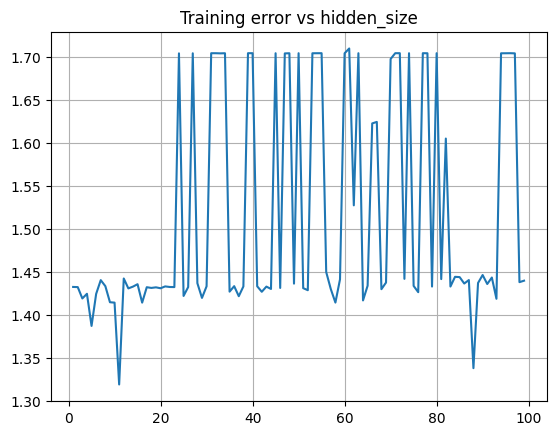

In [16]:
plt.plot(range(1, len(errors)+1), errors)
plt.grid(True)
plt.title('Training error vs hidden_size')

In [31]:
%%time
hidden_sizes = (-torch.tensor(errors)).topk(10).indices + 1
errors = []
results = []
for hidden_size in hidden_sizes:
    print(f'--------------------- Hidden size: {hidden_size} ---------------------')
    rnn = RNN(2, hidden_size, 5)
    res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- Hidden size: 11 ---------------------
Epoch 1
----------------------------------------
Loss = 1.605474
Diff = 999999998.394526

Epoch 2
----------------------------------------
Loss = 1.529233
Diff = 0.076241

Epoch 3
----------------------------------------
Loss = 1.452864
Diff = 0.076369

Epoch 4
----------------------------------------
Loss = 1.443975
Diff = 0.008889

Epoch 5
----------------------------------------
Loss = 1.441282
Diff = 0.002693

Epoch 6
----------------------------------------
Loss = 1.439604
Diff = 0.001678

Epoch 7
----------------------------------------
Loss = 1.438463
Diff = 0.001141

Epoch 8
----------------------------------------
Loss = 1.437539
Diff = 0.000925

Epoch 9
----------------------------------------
Loss = 1.436011
Diff = 0.001527

Epoch 10
----------------------------------------
Loss = 1.435015
Diff = 0.000996

Epoch 11
----------------------------------------
Loss = 1.435000
Diff = 0.000015

--------------------- Hidden

Loss = 1.437508
Diff = 0.001290

Epoch 9
----------------------------------------
Loss = 1.436457
Diff = 0.001051

Epoch 10
----------------------------------------
Loss = 1.435645
Diff = 0.000812

Epoch 11
----------------------------------------
Loss = 1.434878
Diff = 0.000766

Epoch 12
----------------------------------------
Loss = 1.434132
Diff = 0.000746

Epoch 13
----------------------------------------
Loss = 1.433407
Diff = 0.000726

Epoch 14
----------------------------------------
Loss = 1.432692
Diff = 0.000715

Epoch 15
----------------------------------------
Loss = 1.431970
Diff = 0.000721

Epoch 16
----------------------------------------
Loss = 1.431189
Diff = 0.000782

Epoch 17
----------------------------------------
Loss = 1.430224
Diff = 0.000965

Epoch 18
----------------------------------------
Loss = 1.429003
Diff = 0.001221

Epoch 19
----------------------------------------
Loss = 1.427676
Diff = 0.001327

Epoch 20
----------------------------------------
Loss 

Loss = 1.442443
Diff = 0.005819

Epoch 25
----------------------------------------
Loss = 1.445229
Diff = 0.002786

Epoch 26
----------------------------------------
Loss = 1.441406
Diff = 0.003822

Epoch 27
----------------------------------------
Loss = 1.438763
Diff = 0.002643

Epoch 28
----------------------------------------
Loss = 1.438379
Diff = 0.000385

Epoch 29
----------------------------------------
Loss = 1.441362
Diff = 0.002984

Epoch 30
----------------------------------------
Loss = 1.437615
Diff = 0.003747

Epoch 31
----------------------------------------
Loss = 1.440457
Diff = 0.002841

Epoch 32
----------------------------------------
Loss = 1.440656
Diff = 0.000199

Epoch 33
----------------------------------------
Loss = 1.438384
Diff = 0.002272

Epoch 34
----------------------------------------
Loss = 1.437596
Diff = 0.000788

Epoch 35
----------------------------------------
Loss = 1.440035
Diff = 0.002439

Epoch 36
----------------------------------------
Loss

Text(0.5, 1.0, 'Training error vs index')

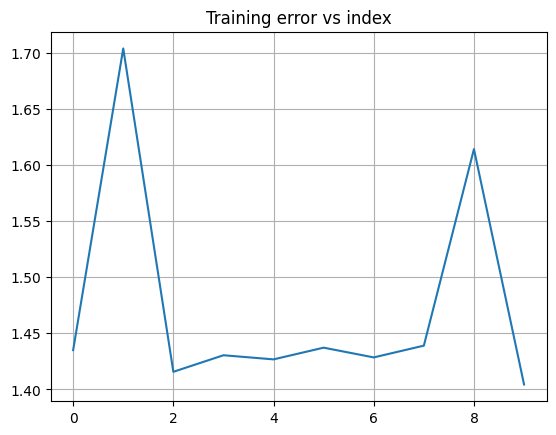

In [44]:
plt.plot(range(len(errors)), errors)
plt.grid(True)
plt.title('Training error vs index')

Text(0.5, 1.0, 'Hidden nodes = 3')

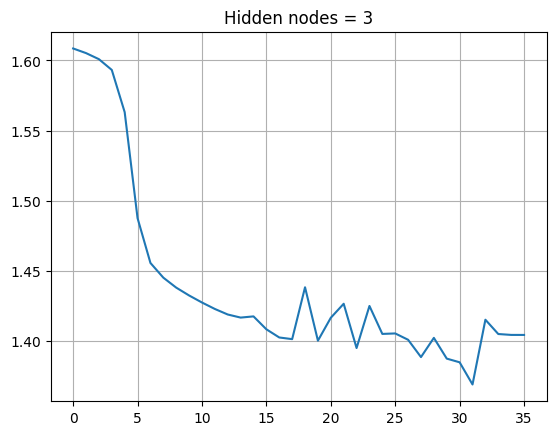

In [50]:
plt.plot(results[9]['errors'])
plt.grid(True)
plt.title('Hidden nodes = 3')

Text(0.5, 1.0, 'Hidden nodes = 5')

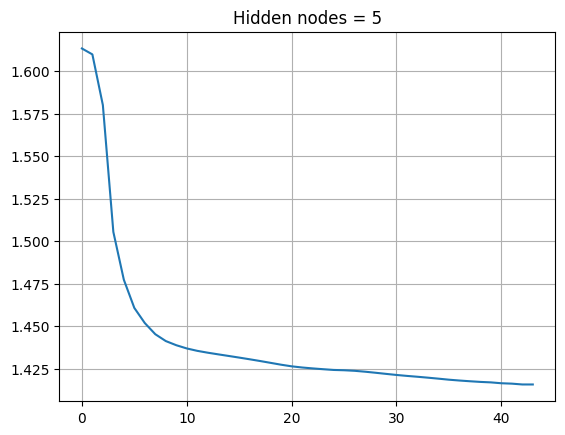

In [51]:
plt.plot(results[2]['errors'])
plt.grid(True)
plt.title('Hidden nodes = 5')

In [52]:
%%time
errors = []
results = []
for num_layers in range(1, 10):
    print(f'--------------------- No of hidden layers: {num_layers} ---------------------')
    rnn = RNN(2, 5, 5, num_layers)
    res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- No of hidden layers: 1 ---------------------
Epoch 1
----------------------------------------
Loss = 1.607884
Diff = 999999998.392116

Epoch 2
----------------------------------------
Loss = 1.596187
Diff = 0.011697

Epoch 3
----------------------------------------
Loss = 1.513551
Diff = 0.082635

Epoch 4
----------------------------------------
Loss = 1.458832
Diff = 0.054719

Epoch 5
----------------------------------------
Loss = 1.446332
Diff = 0.012500

Epoch 6
----------------------------------------
Loss = 1.441402
Diff = 0.004930

Epoch 7
----------------------------------------
Loss = 1.438844
Diff = 0.002558

Epoch 8
----------------------------------------
Loss = 1.437148
Diff = 0.001696

Epoch 9
----------------------------------------
Loss = 1.436068
Diff = 0.001080

Epoch 10
----------------------------------------
Loss = 1.435269
Diff = 0.000799

Epoch 11
----------------------------------------
Loss = 1.434581
Diff = 0.000689

Epoch 12
------------

Loss = 1.611952
Diff = 0.001087

Epoch 3
----------------------------------------
Loss = 1.590965
Diff = 0.020987

Epoch 4
----------------------------------------
Loss = 1.473405
Diff = 0.117560

Epoch 5
----------------------------------------
Loss = 1.468030
Diff = 0.005375

Epoch 6
----------------------------------------
Loss = 1.445577
Diff = 0.022453

Epoch 7
----------------------------------------
Loss = 1.439747
Diff = 0.005831

Epoch 8
----------------------------------------
Loss = 1.437492
Diff = 0.002254

Epoch 9
----------------------------------------
Loss = 1.438023
Diff = 0.000530

Epoch 10
----------------------------------------
Loss = 1.436038
Diff = 0.001985

Epoch 11
----------------------------------------
Loss = 1.447429
Diff = 0.011391

Epoch 12
----------------------------------------
Loss = 1.434702
Diff = 0.012726

Epoch 13
----------------------------------------
Loss = 1.434209
Diff = 0.000493

Epoch 14
----------------------------------------
Loss = 1.43

Text(0.5, 1.0, 'Training error vs num_layers')

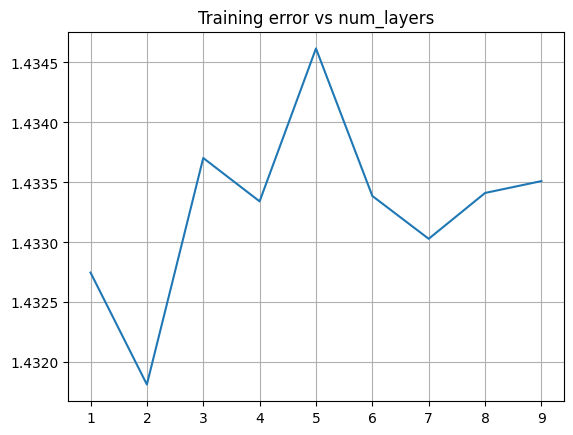

In [54]:
plt.plot(range(1, len(errors)+1), errors)
plt.grid(True)
plt.title('Training error vs num_layers')

In [55]:
%%time
rnn = RNN(2, 5, 5, 2)
res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)

Epoch 1
----------------------------------------
Loss = 1.608391
Diff = 999999998.391609

Epoch 2
----------------------------------------
Loss = 1.580616
Diff = 0.027775

Epoch 3
----------------------------------------
Loss = 1.489741
Diff = 0.090875

Epoch 4
----------------------------------------
Loss = 1.456541
Diff = 0.033200

Epoch 5
----------------------------------------
Loss = 1.446147
Diff = 0.010394

Epoch 6
----------------------------------------
Loss = 1.442120
Diff = 0.004027

Epoch 7
----------------------------------------
Loss = 1.440007
Diff = 0.002113

Epoch 8
----------------------------------------
Loss = 1.438396
Diff = 0.001611

Epoch 9
----------------------------------------
Loss = 1.438148
Diff = 0.000248

Epoch 10
----------------------------------------
Loss = 1.435297
Diff = 0.002851

Epoch 11
----------------------------------------
Loss = 1.435143
Diff = 0.000154

Epoch 12
----------------------------------------
Loss = 1.436231
Diff = 0.001088

Epoch

Text(0.5, 1.0, 'Training error vs epochs\nHidden nodes = 5, No of hidden layers = 2')

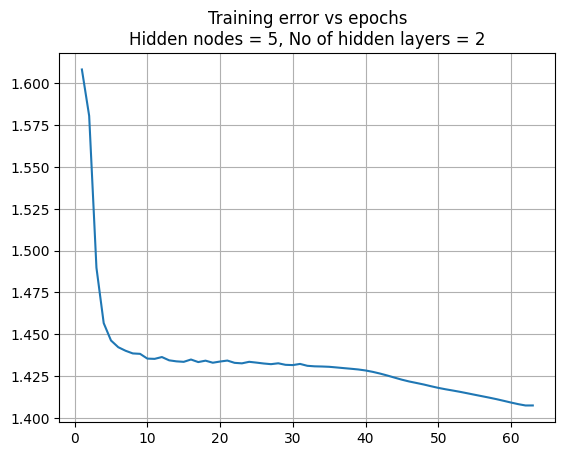

In [58]:
plt.plot(range(1, len(res['errors'])+1), res['errors'])
plt.grid(True)
plt.title('Training error vs epochs\nHidden nodes = 5, No of hidden layers = 2')

In [59]:
print(f'Training accuracy = {calc_acc(train_data, train_label, rnn)}')

Training accuracy = 49.41860465116279


In [60]:
print(f'Test accuracy = {calc_acc(test_data, test_label, rnn)}')

Test accuracy = 48.0


In [30]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fcnn = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, X):
        output, _ = self.lstm(X)
        return self.fcnn(output)[-1]

In [35]:
lstm = LSTM(2, 26, 5, 2)

In [36]:
res = train(train_data, train_label, lstm, lstm.optimizer, lstm.loss_fn, 100, 1e-4, errors=True)

Epoch 1
----------------------------------------
Loss = 1.556052
Diff = 999999998.443948

Epoch 2
----------------------------------------
Loss = 1.422291
Diff = 0.133761

Epoch 3
----------------------------------------
Loss = 1.352141
Diff = 0.070150

Epoch 4
----------------------------------------
Loss = 1.349006
Diff = 0.003135

Epoch 5
----------------------------------------
Loss = 1.299028
Diff = 0.049977

Epoch 6
----------------------------------------
Loss = 1.293009
Diff = 0.006019

Epoch 7
----------------------------------------
Loss = 1.265017
Diff = 0.027992

Epoch 8
----------------------------------------
Loss = 1.270489
Diff = 0.005472

Epoch 9
----------------------------------------
Loss = 1.290279
Diff = 0.019790

Epoch 10
----------------------------------------
Loss = 1.277259
Diff = 0.013020

Epoch 11
----------------------------------------
Loss = 1.231520
Diff = 0.045739

Epoch 12
----------------------------------------
Loss = 1.219803
Diff = 0.011718

Epoch

Loss = 0.923019
Diff = 0.015933



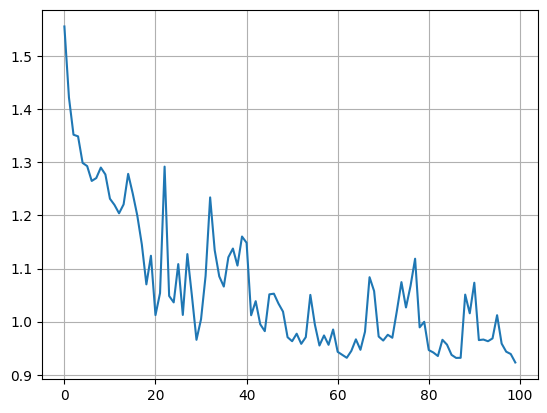

In [42]:
plt.plot(res['errors'])
plt.grid(True)

In [40]:
print(f'Training accuracy = {calc_acc(train_data, train_label, lstm)}')

Training accuracy = 98.83381924198251


In [41]:
print(f'Test accuracy = {calc_acc(test_data, test_label, lstm)}')

Test accuracy = 100.0


# Hyperparameter testing

In [ ]:
%%time
errors = []
results = []
for hidden_size in range(2, 100, 3):
    print(f'--------------------- Hidden size: {hidden_size} ---------------------')
    lstm = LSTM(2, hidden_size, 5)
    res = train(train_data, train_label, lstm, lstm.optimizer, lstm.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- Hidden size: 2 ---------------------
Epoch 1
----------------------------------------
Loss = 1.612654
Diff = 999999998.387346

Epoch 2
----------------------------------------
Loss = 1.611077
Diff = 0.001576

Epoch 3
----------------------------------------
Loss = 1.608407
Diff = 0.002671

Epoch 4
----------------------------------------
Loss = 1.591671
Diff = 0.016736

Epoch 5
----------------------------------------
Loss = 1.536496
Diff = 0.055175

Epoch 6
----------------------------------------
Loss = 1.501677
Diff = 0.034819

Epoch 7
----------------------------------------
Loss = 1.480928
Diff = 0.020749

Epoch 8
----------------------------------------
Loss = 1.468470
Diff = 0.012457

Epoch 9
----------------------------------------
Loss = 1.460272
Diff = 0.008198

Epoch 10
----------------------------------------
Loss = 1.454500
Diff = 0.005772

Epoch 11
----------------------------------------
Loss = 1.450237
Diff = 0.004263

Epoch 12
--------------------

Loss = 1.439856
Diff = 0.000000

--------------------- Hidden size: 11 ---------------------
Epoch 1
----------------------------------------
Loss = 1.605554
Diff = 999999998.394446

Epoch 2
----------------------------------------
Loss = 1.535036
Diff = 0.070517

Epoch 3
----------------------------------------
Loss = 1.475081
Diff = 0.059955

Epoch 4
----------------------------------------
Loss = 1.457126
Diff = 0.017955

Epoch 5
----------------------------------------
Loss = 1.446927
Diff = 0.010199

Epoch 6
----------------------------------------
Loss = 1.442551
Diff = 0.004377

Epoch 7
----------------------------------------
Loss = 1.439139
Diff = 0.003412

Epoch 8
----------------------------------------
Loss = 1.434652
Diff = 0.004487

Epoch 9
----------------------------------------
Loss = 1.433560
Diff = 0.001092

Epoch 10
----------------------------------------
Loss = 1.436776
Diff = 0.003216

Epoch 11
----------------------------------------
Loss = 1.427190
Diff = 0.009

Loss = 1.421211
Diff = 0.005122

Epoch 11
----------------------------------------
Loss = 1.404175
Diff = 0.017037

Epoch 12
----------------------------------------
Loss = 1.419212
Diff = 0.015037

Epoch 13
----------------------------------------
Loss = 1.437002
Diff = 0.017790

Epoch 14
----------------------------------------
Loss = 1.417808
Diff = 0.019194

Epoch 15
----------------------------------------
Loss = 1.416537
Diff = 0.001271

Epoch 16
----------------------------------------
Loss = 1.501877
Diff = 0.085339

Epoch 17
----------------------------------------
Loss = 1.568252
Diff = 0.066375

Epoch 18
----------------------------------------
Loss = 1.459301
Diff = 0.108951

Epoch 19
----------------------------------------
Loss = 1.450370
Diff = 0.008931

Epoch 20
----------------------------------------
Loss = 1.447375
Diff = 0.002995

Epoch 21
----------------------------------------
Loss = 1.478151
Diff = 0.030776

Epoch 22
----------------------------------------
Loss

Loss = 1.435831
Diff = 0.006628

Epoch 9
----------------------------------------
Loss = 1.422771
Diff = 0.013061

Epoch 10
----------------------------------------
Loss = 1.437251
Diff = 0.014480

Epoch 11
----------------------------------------
Loss = 1.425299
Diff = 0.011951

Epoch 12
----------------------------------------
Loss = 1.448564
Diff = 0.023265

Epoch 13
----------------------------------------
Loss = 1.619164
Diff = 0.170599

Epoch 14
----------------------------------------
Loss = 1.442132
Diff = 0.177032

Epoch 15
----------------------------------------
Loss = 1.436729
Diff = 0.005402

Epoch 16
----------------------------------------
Loss = 1.416134
Diff = 0.020595

Epoch 17
----------------------------------------
Loss = 1.344162
Diff = 0.071972

Epoch 18
----------------------------------------
Loss = 1.334456
Diff = 0.009707

Epoch 19
----------------------------------------
Loss = 1.465831
Diff = 0.131375

Epoch 20
----------------------------------------
Loss 

Loss = 1.342824
Diff = 0.020017

Epoch 47
----------------------------------------
Loss = 1.319372
Diff = 0.023452

Epoch 48
----------------------------------------
Loss = 1.312462
Diff = 0.006911

Epoch 49
----------------------------------------
Loss = 1.302645
Diff = 0.009816

Epoch 50
----------------------------------------
Loss = 1.296181
Diff = 0.006465

Epoch 51
----------------------------------------
Loss = 1.445214
Diff = 0.149033

Epoch 52
----------------------------------------
Loss = 1.416052
Diff = 0.029162

Epoch 53
----------------------------------------
Loss = 1.404538
Diff = 0.011514

Epoch 54
----------------------------------------
Loss = 1.393503
Diff = 0.011035

Epoch 55
----------------------------------------
Loss = 1.328641
Diff = 0.064862

Epoch 56
----------------------------------------
Loss = 1.340091
Diff = 0.011450

Epoch 57
----------------------------------------
Loss = 1.270157
Diff = 0.069934

Epoch 58
----------------------------------------
Loss

Loss = 1.289764
Diff = 0.009554

Epoch 38
----------------------------------------
Loss = 1.298985
Diff = 0.009221

Epoch 39
----------------------------------------
Loss = 1.278824
Diff = 0.020161

Epoch 40
----------------------------------------
Loss = 1.289071
Diff = 0.010247

Epoch 41
----------------------------------------
Loss = 1.372818
Diff = 0.083747

Epoch 42
----------------------------------------
Loss = 1.322612
Diff = 0.050206

Epoch 43
----------------------------------------
Loss = 1.346590
Diff = 0.023978

Epoch 44
----------------------------------------
Loss = 1.295269
Diff = 0.051322

Epoch 45
----------------------------------------
Loss = 1.175693
Diff = 0.119576

Epoch 46
----------------------------------------
Loss = 1.240027
Diff = 0.064335

Epoch 47
----------------------------------------
Loss = 1.295017
Diff = 0.054990

Epoch 48
----------------------------------------
Loss = 1.231897
Diff = 0.063120

Epoch 49
----------------------------------------
Loss

Loss = 1.294989
Diff = 0.018666

Epoch 36
----------------------------------------
Loss = 1.274859
Diff = 0.020130

Epoch 37
----------------------------------------
Loss = 1.274737
Diff = 0.000121

Epoch 38
----------------------------------------
Loss = 1.277991
Diff = 0.003254

Epoch 39
----------------------------------------
Loss = 1.276449
Diff = 0.001543

Epoch 40
----------------------------------------
Loss = 1.278843
Diff = 0.002395

Epoch 41
----------------------------------------
Loss = 1.253827
Diff = 0.025017

Epoch 42
----------------------------------------
Loss = 1.266868
Diff = 0.013041

Epoch 43
----------------------------------------
Loss = 1.361215
Diff = 0.094348

Epoch 44
----------------------------------------
Loss = 1.269072
Diff = 0.092143

Epoch 45
----------------------------------------
Loss = 1.234462
Diff = 0.034610

Epoch 46
----------------------------------------
Loss = 1.284199
Diff = 0.049737

Epoch 47
----------------------------------------
Loss

Loss = 1.431312
Diff = 0.001467

Epoch 13
----------------------------------------
Loss = 1.430469
Diff = 0.000842

Epoch 14
----------------------------------------
Loss = 1.429446
Diff = 0.001023

Epoch 15
----------------------------------------
Loss = 1.429306
Diff = 0.000141

Epoch 16
----------------------------------------
Loss = 1.433207
Diff = 0.003902

Epoch 17
----------------------------------------
Loss = 1.434998
Diff = 0.001791

Epoch 18
----------------------------------------
Loss = 1.435663
Diff = 0.000665

Epoch 19
----------------------------------------
Loss = 1.426171
Diff = 0.009492

Epoch 20
----------------------------------------
Loss = 1.424993
Diff = 0.001177

Epoch 21
----------------------------------------
Loss = 1.434088
Diff = 0.009095

Epoch 22
----------------------------------------
Loss = 1.431123
Diff = 0.002965

Epoch 23
----------------------------------------
Loss = 1.434850
Diff = 0.003727

Epoch 24
----------------------------------------
Loss

Loss = 1.601018
Diff = 999999998.398982

Epoch 2
----------------------------------------
Loss = 1.587679
Diff = 0.013339

Epoch 3
----------------------------------------
Loss = 1.459794
Diff = 0.127885

Epoch 4
----------------------------------------
Loss = 1.444225
Diff = 0.015569

Epoch 5
----------------------------------------
Loss = 1.439198
Diff = 0.005027

Epoch 6
----------------------------------------
Loss = 1.443706
Diff = 0.004508

Epoch 7
----------------------------------------
Loss = 1.434801
Diff = 0.008905

Epoch 8
----------------------------------------
Loss = 1.434319
Diff = 0.000482

Epoch 9
----------------------------------------
Loss = 1.431977
Diff = 0.002343

Epoch 10
----------------------------------------
Loss = 1.430459
Diff = 0.001518

Epoch 11
----------------------------------------
Loss = 1.431706
Diff = 0.001247

Epoch 12
----------------------------------------
Loss = 1.429652
Diff = 0.002053

Epoch 13
----------------------------------------
Loss

Loss = 1.452373
Diff = 0.003160

--------------------- Hidden size: 56 ---------------------
Epoch 1
----------------------------------------
Loss = 1.568346
Diff = 999999998.431654

Epoch 2
----------------------------------------
Loss = 1.468638
Diff = 0.099708

Epoch 3
----------------------------------------
Loss = 1.446477
Diff = 0.022162

Epoch 4
----------------------------------------
Loss = 1.440048
Diff = 0.006429

Epoch 5
----------------------------------------
Loss = 1.438523
Diff = 0.001525

Epoch 6
----------------------------------------
Loss = 1.438772
Diff = 0.000248

Epoch 7
----------------------------------------
Loss = 1.432724
Diff = 0.006048

Epoch 8
----------------------------------------
Loss = 1.645019
Diff = 0.212295

Epoch 9
----------------------------------------
Loss = 1.649104
Diff = 0.004084

Epoch 10
----------------------------------------
Loss = 1.437899
Diff = 0.211205

Epoch 11
----------------------------------------
Loss = 1.428791
Diff = 0.009

# Save

In [68]:
%%time
os.chdir('/users/home/b19009/Jupyter_notebooks/DL')
import pickle
with open('results_errors_lstm.pkl', 'wb') as outp:
    pickle.dump((results, errors), outp, pickle.HIGHEST_PROTOCOL)

CPU times: user 1.04 ms, sys: 2 ms, total: 3.04 ms
Wall time: 2.03 ms


# Load

In [30]:
%%time
import pickle
os.chdir('/users/home/b19009/Jupyter_notebooks/DL')
with open('results_errors_lstm.pkl', 'rb') as inp:
    results, errors = pickle.load(inp)

CPU times: user 372 µs, sys: 1.76 ms, total: 2.13 ms
Wall time: 1.42 ms


Text(0.5, 1.0, 'Training error vs hidden_size')

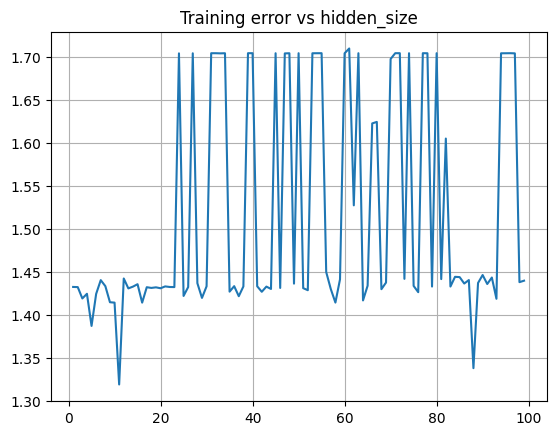

In [16]:
plt.plot(range(1, len(errors)+1), errors)
plt.grid(True)
plt.title('Training error vs hidden_size')

In [31]:
%%time
hidden_sizes = (-torch.tensor(errors)).topk(10).indices + 1
errors = []
results = []
for hidden_size in hidden_sizes:
    print(f'--------------------- Hidden size: {hidden_size} ---------------------')
    rnn = RNN(2, hidden_size, 5)
    res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- Hidden size: 11 ---------------------
Epoch 1
----------------------------------------
Loss = 1.605474
Diff = 999999998.394526

Epoch 2
----------------------------------------
Loss = 1.529233
Diff = 0.076241

Epoch 3
----------------------------------------
Loss = 1.452864
Diff = 0.076369

Epoch 4
----------------------------------------
Loss = 1.443975
Diff = 0.008889

Epoch 5
----------------------------------------
Loss = 1.441282
Diff = 0.002693

Epoch 6
----------------------------------------
Loss = 1.439604
Diff = 0.001678

Epoch 7
----------------------------------------
Loss = 1.438463
Diff = 0.001141

Epoch 8
----------------------------------------
Loss = 1.437539
Diff = 0.000925

Epoch 9
----------------------------------------
Loss = 1.436011
Diff = 0.001527

Epoch 10
----------------------------------------
Loss = 1.435015
Diff = 0.000996

Epoch 11
----------------------------------------
Loss = 1.435000
Diff = 0.000015

--------------------- Hidden

Loss = 1.437508
Diff = 0.001290

Epoch 9
----------------------------------------
Loss = 1.436457
Diff = 0.001051

Epoch 10
----------------------------------------
Loss = 1.435645
Diff = 0.000812

Epoch 11
----------------------------------------
Loss = 1.434878
Diff = 0.000766

Epoch 12
----------------------------------------
Loss = 1.434132
Diff = 0.000746

Epoch 13
----------------------------------------
Loss = 1.433407
Diff = 0.000726

Epoch 14
----------------------------------------
Loss = 1.432692
Diff = 0.000715

Epoch 15
----------------------------------------
Loss = 1.431970
Diff = 0.000721

Epoch 16
----------------------------------------
Loss = 1.431189
Diff = 0.000782

Epoch 17
----------------------------------------
Loss = 1.430224
Diff = 0.000965

Epoch 18
----------------------------------------
Loss = 1.429003
Diff = 0.001221

Epoch 19
----------------------------------------
Loss = 1.427676
Diff = 0.001327

Epoch 20
----------------------------------------
Loss 

Loss = 1.442443
Diff = 0.005819

Epoch 25
----------------------------------------
Loss = 1.445229
Diff = 0.002786

Epoch 26
----------------------------------------
Loss = 1.441406
Diff = 0.003822

Epoch 27
----------------------------------------
Loss = 1.438763
Diff = 0.002643

Epoch 28
----------------------------------------
Loss = 1.438379
Diff = 0.000385

Epoch 29
----------------------------------------
Loss = 1.441362
Diff = 0.002984

Epoch 30
----------------------------------------
Loss = 1.437615
Diff = 0.003747

Epoch 31
----------------------------------------
Loss = 1.440457
Diff = 0.002841

Epoch 32
----------------------------------------
Loss = 1.440656
Diff = 0.000199

Epoch 33
----------------------------------------
Loss = 1.438384
Diff = 0.002272

Epoch 34
----------------------------------------
Loss = 1.437596
Diff = 0.000788

Epoch 35
----------------------------------------
Loss = 1.440035
Diff = 0.002439

Epoch 36
----------------------------------------
Loss

Text(0.5, 1.0, 'Training error vs index')

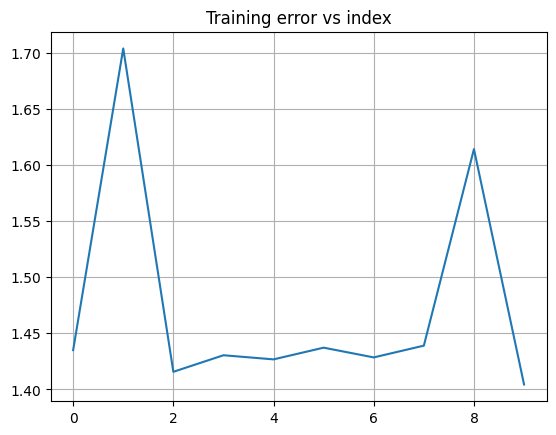

In [44]:
plt.plot(range(len(errors)), errors)
plt.grid(True)
plt.title('Training error vs index')

Text(0.5, 1.0, 'Hidden nodes = 3')

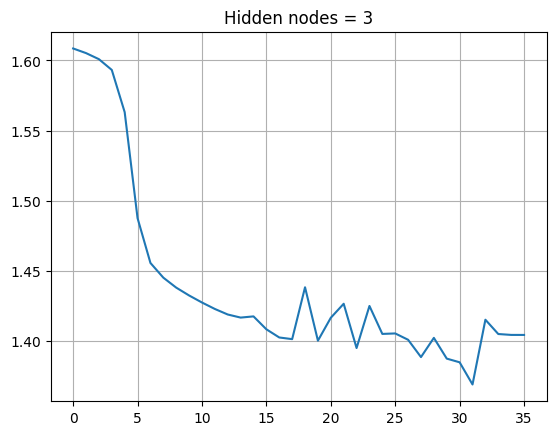

In [50]:
plt.plot(results[9]['errors'])
plt.grid(True)
plt.title('Hidden nodes = 3')

Text(0.5, 1.0, 'Hidden nodes = 5')

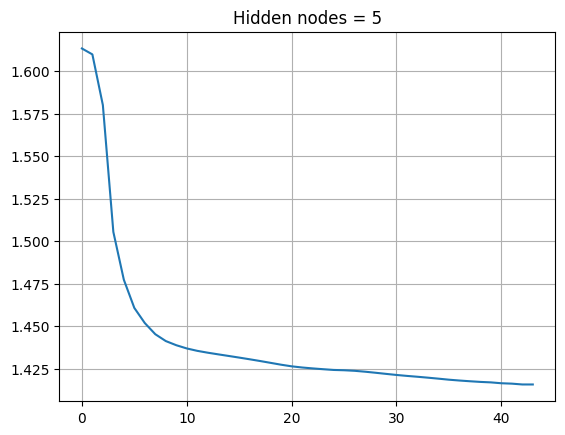

In [51]:
plt.plot(results[2]['errors'])
plt.grid(True)
plt.title('Hidden nodes = 5')

In [52]:
%%time
errors = []
results = []
for num_layers in range(1, 10):
    print(f'--------------------- No of hidden layers: {num_layers} ---------------------')
    rnn = RNN(2, 5, 5, num_layers)
    res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)
    error = res['errors'][-1]
    errors.append(error)
    results.append(res)

--------------------- No of hidden layers: 1 ---------------------
Epoch 1
----------------------------------------
Loss = 1.607884
Diff = 999999998.392116

Epoch 2
----------------------------------------
Loss = 1.596187
Diff = 0.011697

Epoch 3
----------------------------------------
Loss = 1.513551
Diff = 0.082635

Epoch 4
----------------------------------------
Loss = 1.458832
Diff = 0.054719

Epoch 5
----------------------------------------
Loss = 1.446332
Diff = 0.012500

Epoch 6
----------------------------------------
Loss = 1.441402
Diff = 0.004930

Epoch 7
----------------------------------------
Loss = 1.438844
Diff = 0.002558

Epoch 8
----------------------------------------
Loss = 1.437148
Diff = 0.001696

Epoch 9
----------------------------------------
Loss = 1.436068
Diff = 0.001080

Epoch 10
----------------------------------------
Loss = 1.435269
Diff = 0.000799

Epoch 11
----------------------------------------
Loss = 1.434581
Diff = 0.000689

Epoch 12
------------

Loss = 1.611952
Diff = 0.001087

Epoch 3
----------------------------------------
Loss = 1.590965
Diff = 0.020987

Epoch 4
----------------------------------------
Loss = 1.473405
Diff = 0.117560

Epoch 5
----------------------------------------
Loss = 1.468030
Diff = 0.005375

Epoch 6
----------------------------------------
Loss = 1.445577
Diff = 0.022453

Epoch 7
----------------------------------------
Loss = 1.439747
Diff = 0.005831

Epoch 8
----------------------------------------
Loss = 1.437492
Diff = 0.002254

Epoch 9
----------------------------------------
Loss = 1.438023
Diff = 0.000530

Epoch 10
----------------------------------------
Loss = 1.436038
Diff = 0.001985

Epoch 11
----------------------------------------
Loss = 1.447429
Diff = 0.011391

Epoch 12
----------------------------------------
Loss = 1.434702
Diff = 0.012726

Epoch 13
----------------------------------------
Loss = 1.434209
Diff = 0.000493

Epoch 14
----------------------------------------
Loss = 1.43

Text(0.5, 1.0, 'Training error vs num_layers')

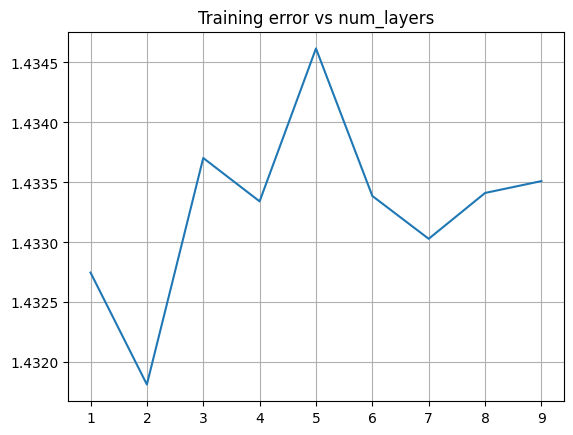

In [54]:
plt.plot(range(1, len(errors)+1), errors)
plt.grid(True)
plt.title('Training error vs num_layers')

In [55]:
%%time
rnn = RNN(2, 5, 5, 2)
res = train(train_data, train_label, rnn, rnn.optimizer, rnn.loss_fn, 100, 1e-4, errors=True)

Epoch 1
----------------------------------------
Loss = 1.608391
Diff = 999999998.391609

Epoch 2
----------------------------------------
Loss = 1.580616
Diff = 0.027775

Epoch 3
----------------------------------------
Loss = 1.489741
Diff = 0.090875

Epoch 4
----------------------------------------
Loss = 1.456541
Diff = 0.033200

Epoch 5
----------------------------------------
Loss = 1.446147
Diff = 0.010394

Epoch 6
----------------------------------------
Loss = 1.442120
Diff = 0.004027

Epoch 7
----------------------------------------
Loss = 1.440007
Diff = 0.002113

Epoch 8
----------------------------------------
Loss = 1.438396
Diff = 0.001611

Epoch 9
----------------------------------------
Loss = 1.438148
Diff = 0.000248

Epoch 10
----------------------------------------
Loss = 1.435297
Diff = 0.002851

Epoch 11
----------------------------------------
Loss = 1.435143
Diff = 0.000154

Epoch 12
----------------------------------------
Loss = 1.436231
Diff = 0.001088

Epoch

Text(0.5, 1.0, 'Training error vs epochs\nHidden nodes = 5, No of hidden layers = 2')

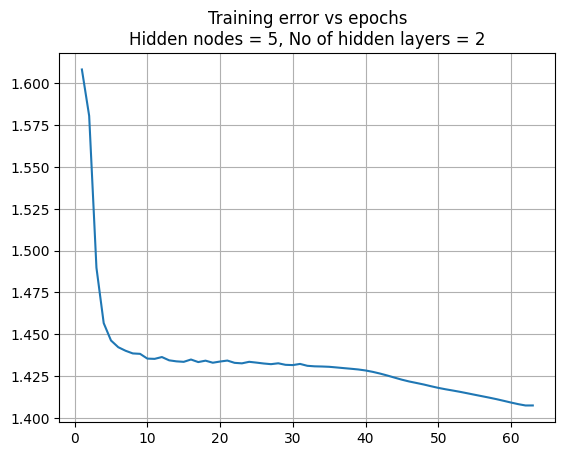

In [58]:
plt.plot(range(1, len(res['errors'])+1), res['errors'])
plt.grid(True)
plt.title('Training error vs epochs\nHidden nodes = 5, No of hidden layers = 2')

In [59]:
print(f'Training accuracy = {calc_acc(train_data, train_label, rnn)}')

Training accuracy = 49.41860465116279


In [60]:
print(f'Test accuracy = {calc_acc(test_data, test_label, rnn)}')

Test accuracy = 48.0


In [117]:
lstm = LSTM(2, 20, 5)

In [118]:
%%time
errors = train(train_data, train_label, lstm, lstm.optimizer, lstm.loss_fn, 100, 1e-4, return_errors=True)

Epoch 1
----------------------------------------
Loss = 1.599043
Diff = 999999998.400957

Epoch 2
----------------------------------------
Loss = 1.477755
Diff = 0.121288

Epoch 3
----------------------------------------
Loss = 1.445671
Diff = 0.032084

Epoch 4
----------------------------------------
Loss = 1.441645
Diff = 0.004026

Epoch 5
----------------------------------------
Loss = 1.435848
Diff = 0.005797

Epoch 6
----------------------------------------
Loss = 1.435904
Diff = 0.000056

CPU times: user 30.6 s, sys: 9.69 ms, total: 30.6 s
Wall time: 30.6 s


Text(0.5, 1.0, 'Training error vs epochs')

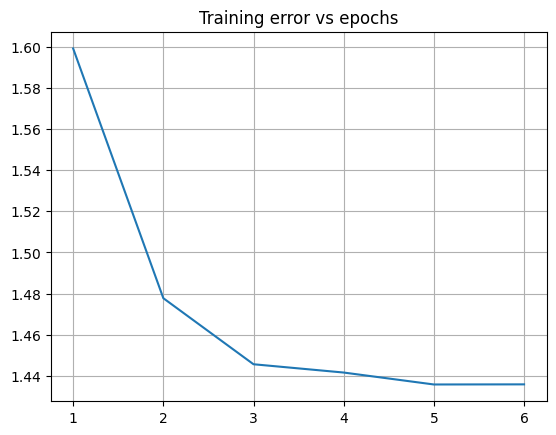

In [122]:
plt.plot(range(1, len(errors)+1), errors)
plt.grid(True)
plt.title('Training error vs epochs')

In [123]:
print(f'Training accuracy = {calc_acc(train_data, train_label, lstm)}')

Training accuracy = 42.73255813953488


In [124]:
print(f'Test accuracy = {calc_acc(test_data, test_label, lstm)}')

Test accuracy = 44.0
